# Hotter Summers

Since we moved to California, its really hard to tell if summers are cooler, or we're just getting alimatized. Question answered with data.

Victoria, BC also analyzed.

In [151]:
import pandas as pd
import requests
import os
import datetime as dt
import StringIO
from dateutil import relativedelta
%pylab inline

rcParams['figure.figsize'] = [12,8]


Populating the interactive namespace from numpy and matplotlib


In [152]:
LOCATION = 'LIVERMORE'
# LOCATION = 'VICTORIA'

if LOCATION == 'LIVERMORE':
  FILEFORMAT = 'NOAA' # NOAA or EnvCanada
  SRC_FILE = 'NOAA1484120.csv'
elif LOCATION == 'VICTORIA':
  FILEFORMAT = 'EnvCan' # NOAA or EnvCanada
  SRC_FILE = 'EC51337.csv'



In [153]:
# Run this cell to download Canadian data
def download_environment_canada(station_id,start_year=2015):
  filename = 'EC{}.csv'.format(station_id)
  if os.path.exists(filename):
    return pd.read_csv(filename)
    
  url = 'http://climate.weather.gc.ca/climate_data/bulk_data_e.html'
  params = {'stationID':station_id,
           'timeframe':1,
          'format':'csv'
           }
  
  request_date = dt.datetime(start_year,1,1)
  end_date = dt.datetime.now()
  c = pd.DataFrame()
  while request_date < end_date:
    params['Year'] = request_date.year
    params['Month'] = request_date.month
    r = requests.get(url=url, params=params)
    sio = StringIO.StringIO(r.content)
    try:
      temp_df = pd.read_csv(sio,skiprows=15)
    except ParserError:
      print r.content
    c = pd.concat([c,temp_df])
    request_date += relativedelta(months=1)
  c.to_csv(filename)

# Download and Save Environment Canada Data for Victoria, BC
download_environment_canada(51337)

In [154]:
def _F_to_C(tempF):
  """Convert 'freedom-degress' to 'civilized-degress'."""
  return (tempF-32.)*5./9.

assert _F_to_C(212) == 100
assert _F_to_C(32) == 0

In [155]:
# Load data and convert data and temp columns
df = pd.read_csv(SRC_FILE)
if FILEFORMAT == 'NOAA':
  df['timestamp'] = pd.to_datetime(df['DATE'])
  df['temp'] = pd.to_numeric(df['HOURLYDRYBULBTEMPC'],errors='coerce')
if FILEFORMAT == 'EnvCan':
  df['timestamp'] = pd.to_datetime(df['Date/Time'])
  df['temp'] = pd.to_numeric(df['Temp (°C)'],errors='coerce')
    
df['year'] = df['timestamp'].dt.year
df['day_of_year'] = df['timestamp'].dt.dayofyear

Text(0,0.5,u'Temperature (C)')

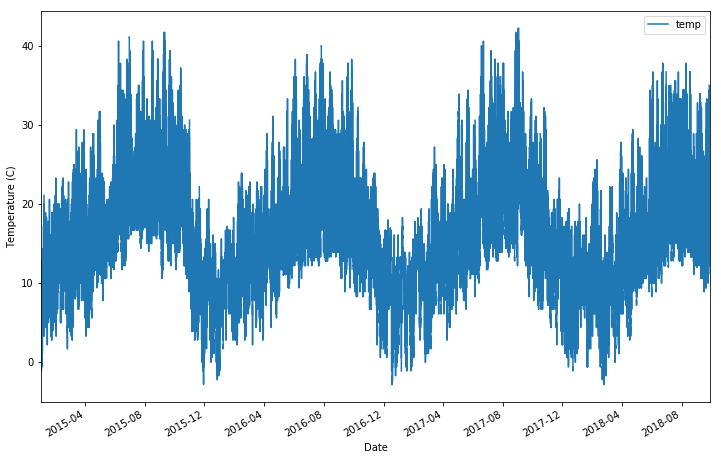

In [156]:
# Plot Temperatures
df.plot(x='timestamp',y='temp')
xlabel('Date')
ylabel('Temperature (C)')

Text(0,0.5,u'Temperature (C)')

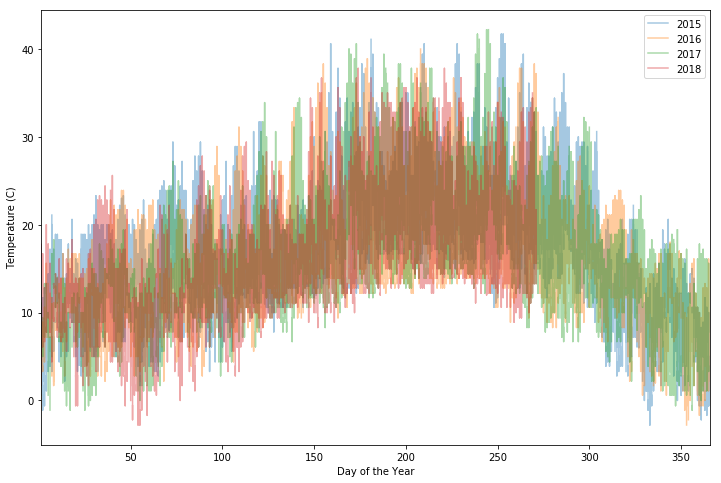

In [157]:
# Plot overlayed years of temperature
years = df.year.unique()
fig,ax=subplots(1,1)
for y in years:
  df[df.year==y].plot(x='day_of_year',y='temp',ax=ax,alpha=0.4,label=y)
  
xlabel('Day of the Year')
ylabel('Temperature (C)')

Text(0,0.5,u'Hours above at Temperature')

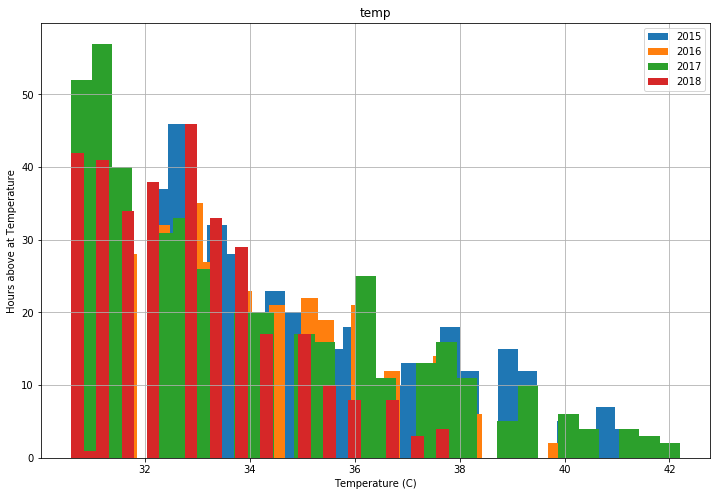

In [158]:
# Plot histogram of high temperature datys
if LOCATION == 'VICTORIA':
  _threshold = 24.
elif LOCATION == 'LIVERMORE':
  _threshold = 30.
  
fig,ax=subplots(1,1)
for y in years:
  df[(df.year==y)&(df['temp']>_threshold)].hist('temp',ax=ax,bins=30)
legend(years)

xlabel('Temperature (C)')
ylabel('Hours above at Temperature')


Text(0.5,1,u'Hot Hours at Livermore Airport')

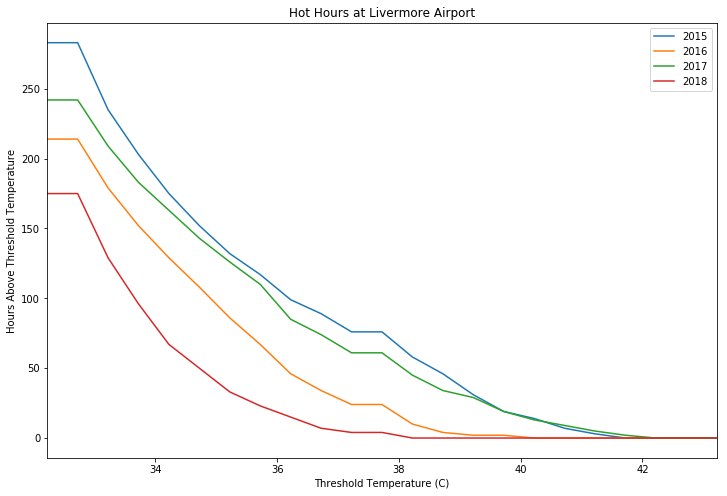

In [159]:
if LOCATION == 'VICTORIA':
  _low_threshold = 24.
  _high_threshold = 32.
elif LOCATION == 'LIVERMORE':
  _low_threshold = _F_to_C(90.)
  _high_threshold = _F_to_C(110.)

data = []
for thresh in np.arange(_low_threshold,_high_threshold,0.5):
  this_data = {'threshold':thresh}
  for y in years:
    this_data[y] = len(df[(df.year==y)&(df['temp']>thresh)])
  data.append(this_data)

df2 = pd.DataFrame(data)
df2.index = df2.threshold


df2.plot(x='threshold')
xlabel('Threshold Temperature (C)')
ylabel('Hours Above Threshold Temperature')
title('Hot Hours at {} Airport'.format(LOCATION.capitalize()))